# 0. Preparation

## (Optoinal) mount google drive
- Make sure that available access is the user's own drive(no access across files in shared folder)

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

2023-04-01 21:06:37.196118: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-01 21:06:37.243686: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-01 21:06:37.244757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 21:06:37.987099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 42
Global seed set to 42


42

# Load data from Azure blob

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Download full data
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"
local_file = tmp_dir + os.sep + blob_name

data_df = get_raw_datasets(container, blob_name)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Eval Model

In [5]:
exp_model_dir = "/root/co2-flux-hourly-gpp-modeling/data/models/tft_model_13_1_yes_koppen_2Y_3D_230401_0511" # TODO: Replace to your model dir
best_model_path = "/root/co2-flux-hourly-gpp-modeling/data/models/tft_model_13_1_yes_koppen_2Y_3D_230401_0511/lightning_logs/version_0/checkpoints/epoch=10-step=55077.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*2 # 1 year
ENCODER_LEN = 24*3   # 3 days
print(f"Training timestemp length = {SUBSET_LEN}.")

# create dataloaders for model
# ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
batch_size = 256  # set this between 32 to 128
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
Training timestemp length = 17520.


In [6]:
def setup_tsdataset_yeskoppensub(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["koppen_main", "koppen_sub"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7'],
      time_varying_unknown_categoricals=["gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

In [7]:
# Setup dataset
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
_, validation, _ = setup_tsdataset_yeskoppensub(train_df, val_df, None, ENCODER_LEN)

Subest length: 17520 timesteps for each sites
Subset num train timesteps: 1287576
Subset num val timesteps: 446760


## Default Evaluation

In [8]:
# # Eval on Validation set
# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

# # Print Model Eval on Validation Set
# start = default_timer()
# print(f"Start eval on validation.")
# val_q_predictions = best_tft.predict(val_dataloader, mode="quantiles", show_progress_bar=True, return_x=False)
# eval_time = default_timer() - start
# print(f"Val eval time: {eval_time}")

# # Get actuals
# val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

# # save eval results - also we can resume eval at a later point in time
# with open(exp_model_dir + os.sep + "val_actuals.pkl", "wb") as fout:
#     pickle.dump(val_actuals, fout)

# with open(exp_model_dir + os.sep + "val_q_predictions.pkl", "wb") as fout:
#     pickle.dump(val_q_predictions, fout)

In [9]:
# reload = False

# if reload:
#     # load eval results - also we can resume eval at a later point in time
#     with open(exp_model_dir + os.sep + "val_actuals.pkl", "rb") as fin:
#         val_actuals = pickle.load(fin)

#     with open(exp_model_dir + os.sep + "val_q_predictions.pkl", "rb") as fin:
#         val_q_predictions = pickle.load(fin)

#     #Eval on Validation set
#     val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

    
# val_predictions = val_q_predictions[:, :, 3] # p50 == estimation
# val_p90 = val_q_predictions[:, :,5] # p90 == estimation
# #del val_q_predictions

# # Unmasked evaltaion
# eval_metric = get_eval_metrics(val_actuals, val_predictions, None, val_p90)
# print(f"Unmasked Val eval evaluation: {eval_metric}")

# # Masked evlationa
# start = default_timer()
# mask = torch.logical_not(torch.cat([x['decoder_cat'][:, :, -1].reshape(-1) for x, y in iter(val_dataloader)]))
# masked_eval_metric = get_eval_metrics(val_actuals, val_predictions, mask, val_p90)
# eval_time = default_timer() - start
# print(f"Masked Val eval time: {eval_time}")
# print(f"Masked Val eval evaluation: {masked_eval_metric}")

# Model Interpreation

In [10]:
# Setup dataset
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
_, validation, _ = setup_tsdataset_yeskoppensub(train_df, val_df, None, ENCODER_LEN)
raw_predictions = best_tft.predict(validation, mode="raw") #,  show_progress_bar=True)

Subest length: 17520 timesteps for each sites
Subset num train timesteps: 1287576
Subset num val timesteps: 446760


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x700 with 1 Axes>,
 'decoder_variables': <Figure size 700x675 with 1 Axes>}

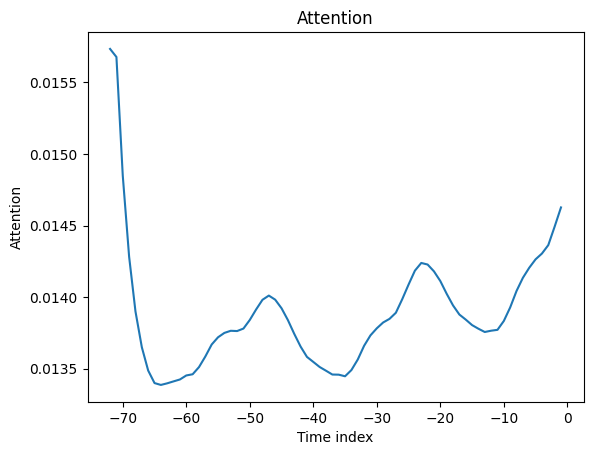

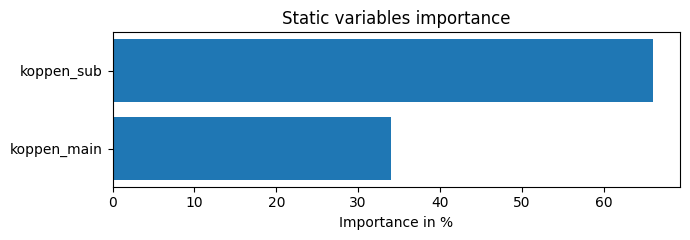

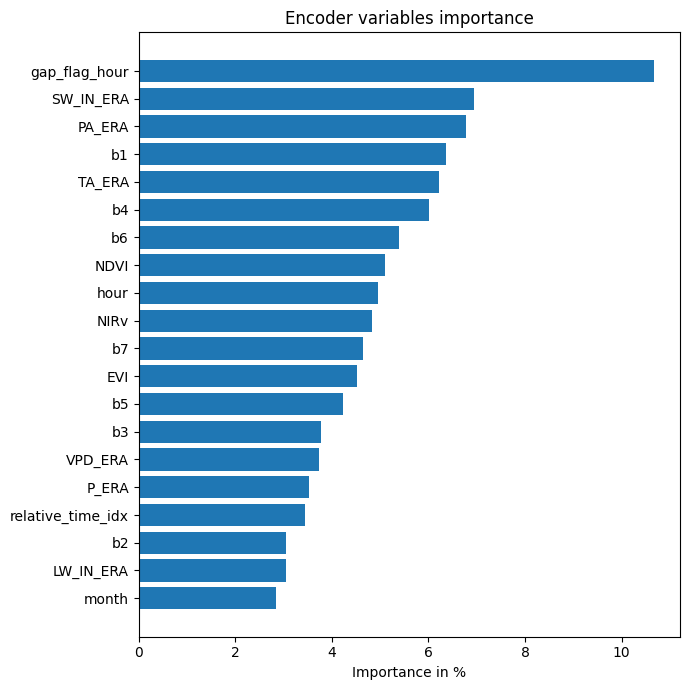

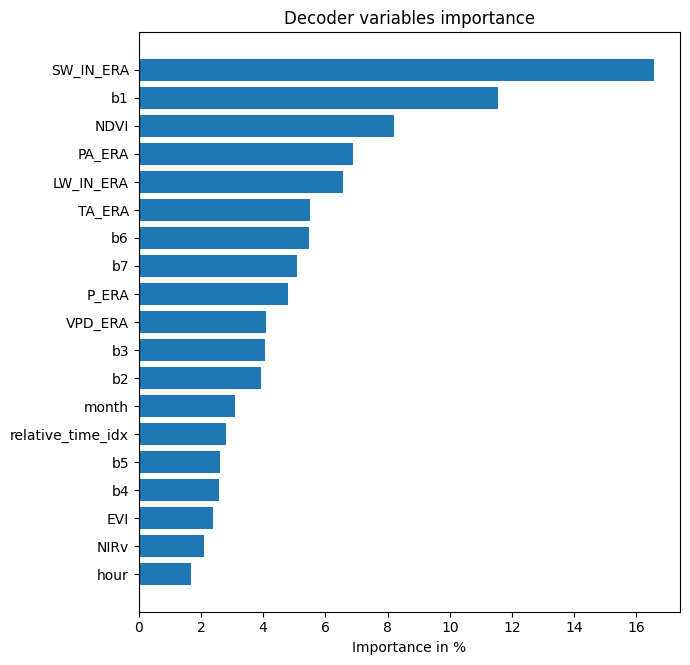

In [11]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

## Feature-Level Attention

In [29]:
interpretation_none = best_tft.interpret_output(raw_predictions, reduction="none")

In [49]:
# Determine which features align to "encoder_variables", validate against imoprtances above
enc_var_means = torch.mean(interpretation_none['encoder_variables'], dim=0).numpy()
time_varying_known_categoricals=["month", "hour"]
time_varying_unknown_categoricals=["gap_flag_hour"]
time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                        'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']
enc_var_names = time_varying_known_categoricals + time_varying_unknown_categoricals + time_varying_known_reals + ['relative_time_idx']
feature_imp_dict = dict(zip(enc_var_names, enc_var_means))
feature_imp_dict

{'month': 0.028324787,
 'hour': 0.049498517,
 'gap_flag_hour': 0.10673966,
 'TA_ERA': 0.06217903,
 'SW_IN_ERA': 0.06934912,
 'LW_IN_ERA': 0.030455751,
 'VPD_ERA': 0.03727142,
 'P_ERA': 0.03516264,
 'PA_ERA': 0.067687094,
 'EVI': 0.045124263,
 'NDVI': 0.05109566,
 'NIRv': 0.048266925,
 'b1': 0.06355717,
 'b2': 0.030548163,
 'b3': 0.037674215,
 'b4': 0.06014418,
 'b5': 0.042214293,
 'b6': 0.05395908,
 'b7': 0.04638455,
 'relative_time_idx': 0.034363467}

In [15]:
for key in raw_predictions.keys():
    print(f"key: {key}, shape: {raw_predictions[key].shape}")

key: prediction, shape: torch.Size([444888, 1, 7])
key: encoder_attention, shape: torch.Size([444888, 1, 1, 72])
key: decoder_attention, shape: torch.Size([444888, 1, 1, 1])
key: static_variables, shape: torch.Size([444888, 1, 2])
key: encoder_variables, shape: torch.Size([444888, 72, 1, 20])
key: decoder_variables, shape: torch.Size([444888, 1, 1, 19])
key: decoder_lengths, shape: torch.Size([444888])
key: encoder_lengths, shape: torch.Size([444888])


### Investigate feature importances for 1 prediction

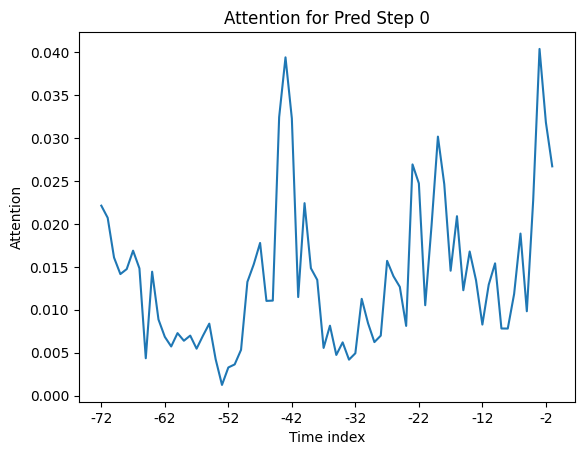

In [63]:
# attention
fig, ax = plt.subplots()
attention = interpretation_none["attention"][pred_ind].detach().cpu()
attention = attention / attention.sum(-1).unsqueeze(-1)
ax.plot(attention)
ax.set_xlabel("Time index")
ax.set_ylabel("Attention")
ax.set_title(f"Attention for Pred Step {i}")
xticks_locations = range(0, len(attention), 10)
xticks_labels = range(-len(attention), 0, 10)
plt.xticks(xticks_locations, xticks_labels)
plt.show()

In [66]:
# Get top timestep for pred 1
pred_ind = 0
ind = raw_predictions["encoder_attention"][pred_ind][0][0].argmax()
print(f"Top encoder attention index is for pred {pred_ind} is {ind-ENCODER_LEN}")

# Which feature is most important at this prediction step?
enc_vars_at_ind = raw_predictions["encoder_variables"][pred_ind][ind]
enc_ind = torch.argmax(enc_vars_at_ind)
feat_ind = enc_var_names[enc_ind]
print(f"Most important feature at index {ind-ENCODER_LEN} is {feat_ind}")

Top encoder attention index is for pred 0 is -3
Most important feature at index -3 is b5


In [67]:
# Whay do we care the most about? We probably care about analyzing the aggregate attention line chart. At each peak, what are the feature importances?

In [74]:
# Pick one step, find the highest attention timestep, find 
pred_feat_importances = torch.mean(raw_predictions["encoder_variables"][pred_ind], dim=0)[0].numpy()

print(f"Prediction-Level Feature Importances at Pred Step {pred_ind}, across all encoder inds")
pred_feature_imp_dict = dict(zip(enc_var_names, pred_feat_importances))
sorted_dict = dict(sorted(pred_feature_imp_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict)

Prediction-Level Feature Importances at Pred Step 0
{'b5': 0.20803253, 'SW_IN_ERA': 0.11453584, 'b1': 0.08182821, 'b4': 0.078445375, 'gap_flag_hour': 0.0715403, 'VPD_ERA': 0.060746472, 'PA_ERA': 0.056022696, 'TA_ERA': 0.046435893, 'b3': 0.04609677, 'EVI': 0.036373857, 'b6': 0.03418396, 'LW_IN_ERA': 0.031251434, 'b2': 0.027996136, 'relative_time_idx': 0.025384333, 'hour': 0.024478883, 'NIRv': 0.018175304, 'month': 0.01720973, 'NDVI': 0.010877694, 'b7': 0.008357693, 'P_ERA': 0.002026882}
